In [ ]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

In [ ]:
#Execute them for first to install
if IN_COLAB:
    !pip install xgboost --upgrade
    !pip install category_encoders
    !pip install feature-engine

Requirement already up-to-date: xgboost in /usr/local/lib/python3.6/dist-packages (1.1.1)


### Problem Statement
> A retail company “ABC Private Limited” wants to understand the customer purchase behaviour (specifically, purchase amount) against various products of different categories. They have shared purchase summary of various customers for selected high volume products from last month.
The data set also contains customer demographics (age, gender, marital status, city_type, stay_in_current_city), product details (product_id and product category) and Total purchase_amount from last month.
Now, they want to build a model to predict the purchase amount of customer against various products which will help them to create personalized offer for customers against different products.

|Variable|Definition|
|:---- |:----
|User_ID|User ID|
|Product_ID|Product ID|
|Gender|Sex of User|
|Age|Age in bins|
|Occupation|Occupation (Masked)|
|City_Category|Category of the City (A,B,C)|
|Stay_In_Current_City_Years|Number of years stay in current city|
|Marital_Status|Marital Status|
|Product_Category_1|Product Category (Masked)|
|Product_Category_2|Product may belongs to other category also (Masked)|
|Product_Category_3|Product may belongs to other category also (Masked)|
|Purchase|Purchase Amount (Target Variable)|

### Evaluation
Submissions are scored on the root mean squared error (RMSE). RMSE is very common and is a suitable general-purpose error metric. Compared to the Mean Absolute Error, RMSE punishes large errors:



In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
import pandas_profiling
import seaborn as sns
from matplotlib import pyplot as plt

import scipy.stats as stats
from scipy.stats import chi2_contingency
import category_encoders as ce

In [ ]:
import xgboost as xgb
from xgboost import XGBRegressor
from hyperopt import hp,fmin,tpe
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError
from yellowbrick.regressor import AlphaSelection
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error

def residual_plot(model,X_train, y_train,X_validation, y_validation):
    visualizer = ResidualsPlot(model)
    visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
    visualizer.score(X_validation, y_validation)  # Evaluate the model on the test data
    visualizer.show()         

def prediction_error(model,X_train, y_train,X_validation, y_validation):
    visualizer = PredictionError(model)
    visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
    visualizer.score(X_validation, y_validation)  # Evaluate the model on the test data
    visualizer.show()  

def show_learning_curve(model,X_train, y_train,X_validation, y_validation):
    train_sizes, train_scores, validation_scores = learning_curve(
        model, X_train, y_train.values.ravel(), cv=5)
    plot_learning_curve(train_sizes, train_scores, validation_scores)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
%matplotlib inline

In [ ]:
def extended_describe(dataframe):
    extended_describe_df= dataframe.describe(include='all').T 
    extended_describe_df['null_count']= dataframe.isnull().sum()
    extended_describe_df['unique_count'] = dataframe.apply(lambda x: len(x.unique()))
    return extended_describe_df 

In [ ]:
from collections import Counter
def detect_outliers(dataset , noutliers , columns):
    outlier_indices = []
    for column in columns:
        # 1st quartile (25%),# 3rd quartile (75%)
        q1 , q3 = np.percentile(dataset[column] , [25 , 75])

        # Interquartile range (IQR)
        iqr = q3 - q1

        # outlier step
        outlier_step = 1.5 * iqr

        lower_bound = q1 - outlier_step
        upper_bound = q3 + outlier_step

        # Determine a list of indices of outliers for feature col
        outlier_list_col = dataset[(dataset[column] < lower_bound) | (
        dataset[column] > upper_bound)].index
        outlier_indices.extend(outlier_list_col)

    outlier_indices = Counter(outlier_indices)
 
    multiple_outliers = list(k for k , v in outlier_indices.items()
                             if v > noutliers)

    return outlier_indices

In [ ]:
def merge_df(left_df,right_df,how,on,suffixes):
    if not on:
        raise valueError("Unable to join dataframes as join cols not specified")
    how = how or 'left'
    suffixes = suffixes or ('_left','_right')
    return  left_df.merge(right=right_df,how =how,on =on,suffixes=suffixes)

In [ ]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    data_path = 'drive/My Drive/datasource/blackfriday/{file}'
    source_path = Path.cwd()
else:
    data_path='{file}'
    source_path =Path.cwd().joinpath('datasource')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_file = source_path.joinpath(data_path.format(file='train.csv'))
test_file =  source_path.joinpath(data_path.format(file='test.csv'))

In [ ]:
train_df = pd.read_csv(train_file)

test_df = pd.read_csv(test_file)

test_df_copy = test_df.copy(deep=True)

In [ ]:
extended_describe(train_df)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,null_count,unique_count
User_ID,550068,NaN,NaN,NaN,1.00303e+06,1727.59,1e+06,1.00152e+06,1.00308e+06,1.00448e+06,1.00604e+06,0,5891
Product_ID,550068,3631,P00265242,1880,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3631
Gender,550068,2,M,414259,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2
Age,550068,7,26-35,219587,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,7
Occupation,550068,NaN,NaN,NaN,8.07671,6.52266,0,2,7,14,20,0,21
City_Category,550068,3,B,231173,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3
Stay_In_Current_City_Years,550068,5,1,193821,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,5
Marital_Status,550068,NaN,NaN,NaN,0.409653,0.49177,0,0,0,1,1,0,2
Product_Category_1,550068,NaN,NaN,NaN,5.40427,3.93621,1,1,5,8,20,0,20
Product_Category_2,376430,NaN,NaN,NaN,9.84233,5.08659,2,5,9,15,18,173638,18


In [ ]:
extended_describe(test_df)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,null_count,unique_count
User_ID,233599,NaN,NaN,NaN,1.00303e+06,1726.5,1e+06,1.00153e+06,1.00307e+06,1.00448e+06,1.00604e+06,0,5891
Product_ID,233599,3491,P00265242,829,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3491
Gender,233599,2,M,175772,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2
Age,233599,7,26-35,93428,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,7
Occupation,233599,NaN,NaN,NaN,8.08541,6.52115,0,2,7,14,20,0,21
City_Category,233599,3,B,98566,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3
Stay_In_Current_City_Years,233599,5,1,82604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,5
Marital_Status,233599,NaN,NaN,NaN,0.41007,0.491847,0,0,0,1,1,0,2
Product_Category_1,233599,NaN,NaN,NaN,5.27654,3.73638,1,1,5,8,18,0,18
Product_Category_2,161255,NaN,NaN,NaN,9.84959,5.09494,2,5,9,15,18,72344,18


In [ ]:
train_df.groupby(['User_ID'])['Purchase'].agg(['mean', 'count'])

,mean,count
User_ID,,
1000001,9545.514286,35
1000002,10525.610390,77
1000003,11780.517241,29
1000004,14747.714286,14
1000005,7745.292453,106
...,...,...
1006036,8007.894942,514
1006037,9176.540984,122
1006038,7502.833333,12


In [ ]:
outliers = detect_outliers(train_df,2,["Purchase"])

In [ ]:
remove_idx = list(outliers.keys())
train_df.drop(remove_idx,inplace=True,axis =0)

In [ ]:
y = train_df['Purchase']
X = train_df.drop(['Purchase'],axis=1)

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 547391 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     547391 non-null  int64  
 1   Product_ID                  547391 non-null  object 
 2   Gender                      547391 non-null  object 
 3   Age                         547391 non-null  object 
 4   Occupation                  547391 non-null  int64  
 5   City_Category               547391 non-null  object 
 6   Stay_In_Current_City_Years  547391 non-null  object 
 7   Marital_Status              547391 non-null  int64  
 8   Product_Category_1          547391 non-null  int64  
 9   Product_Category_2          374165 non-null  float64
 10  Product_Category_3          166180 non-null  float64
 11  Purchase                    547391 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 54.3+ MB


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233599 entries, 0 to 233598
Data columns (total 11 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     233599 non-null  int64  
 1   Product_ID                  233599 non-null  object 
 2   Gender                      233599 non-null  object 
 3   Age                         233599 non-null  object 
 4   Occupation                  233599 non-null  int64  
 5   City_Category               233599 non-null  object 
 6   Stay_In_Current_City_Years  233599 non-null  object 
 7   Marital_Status              233599 non-null  int64  
 8   Product_Category_1          233599 non-null  int64  
 9   Product_Category_2          161255 non-null  float64
 10  Product_Category_3          71037 non-null   float64
dtypes: float64(2), int64(4), object(5)
memory usage: 19.6+ MB


In [ ]:
cols=['Gender','City_Category',]

In [ ]:
cb_enc = ce.one_hot.OneHotEncoder(verbose=1, cols=cols,use_cat_names=True)
cb_enc.fit(X,y)
X = cb_enc.transform(X)
test_df = cb_enc.transform(test_df)

In [ ]:
X.head()

,User_ID,Product_ID,Gender_F,Gender_M,Age,Occupation,City_Category_A,City_Category_C,City_Category_B,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3
0,1000001,P00069042,1,0,0-17,10,1,0,0,2,0,3,NaN,NaN
1,1000001,P00248942,1,0,0-17,10,1,0,0,2,0,1,6.0,14.0
2,1000001,P00087842,1,0,0-17,10,1,0,0,2,0,12,NaN,NaN
3,1000001,P00085442,1,0,0-17,10,1,0,0,2,0,12,14.0,NaN
4,1000002,P00285442,0,1,55+,16,0,1,0,4+,0,8,NaN,NaN


In [ ]:
def get_mapper(df,feature,target):
    return df.groupby([feature])[target].sum().rank(ascending= False).to_dict()

In [ ]:
def get_mean_mapper(df,feature,target):
    return df.groupby([feature])[target].mean().to_dict()

In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233599 entries, 0 to 233598
Data columns (total 14 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     233599 non-null  int64  
 1   Product_ID                  233599 non-null  object 
 2   Gender_F                    233599 non-null  int64  
 3   Gender_M                    233599 non-null  int64  
 4   Age                         233599 non-null  object 
 5   Occupation                  233599 non-null  int64  
 6   City_Category_A             233599 non-null  int64  
 7   City_Category_C             233599 non-null  int64  
 8   City_Category_B             233599 non-null  int64  
 9   Stay_In_Current_City_Years  233599 non-null  object 
 10  Marital_Status              233599 non-null  int64  
 11  Product_Category_1          233599 non-null  int64  
 12  Product_Category_2          161255 non-null  float64
 13  Product_Catego

In [ ]:
occupation_mapper = get_mapper(train_df,'Occupation','Purchase')
age_mapper = get_mapper(train_df,'Age','Purchase')
stay_in_city_mapper = get_mapper(train_df,'Stay_In_Current_City_Years','Purchase')
product_id_mapper = get_mean_mapper(train_df,'Product_ID','Purchase')
user_id_mapper = train_df['User_ID'].value_counts().to_dict() 
user_id_avg_mapper = get_mean_mapper(train_df,'User_ID','Purchase')

In [ ]:
X['Occupation']= X['Occupation'].map(lambda x:occupation_mapper.get(x,-1)).astype('int')
test_df['Occupation']= test_df['Occupation'].map(lambda x:occupation_mapper.get(x,-1)).astype('int')

In [ ]:
X['Age_tr']= X['Age'].map(lambda x:age_mapper.get(x,-1)).astype('int')
test_df['Age_tr']= test_df['Age'].map(lambda x:age_mapper.get(x,-1)).astype('int')

In [ ]:
 
X['Stay_In_Current_City_Years']= X['Stay_In_Current_City_Years'].map(lambda x:stay_in_city_mapper.get(x,-1)).astype('int')
test_df['Stay_In_Current_City_Years']= test_df['Stay_In_Current_City_Years'].map(lambda x:stay_in_city_mapper.get(x,-1)).astype('int')

In [ ]:
X['Purchase_Avg_By_Product_ID']= X['Product_ID'].map(lambda x:product_id_mapper.get(x,-1)).astype('int')
test_df['Purchase_Avg_By_Product_ID']= test_df['Product_ID'].map(lambda x:product_id_mapper.get(x,-1)).astype('int')

In [ ]:
X['Purchase_Avg_By_User_ID']= X['User_ID'].map(lambda x:user_id_avg_mapper.get(x,-1)).astype('int')
test_df['Purchase_Avg_By_User_ID']= test_df['User_ID'].map(lambda x:user_id_avg_mapper.get(x,-1)).astype('int')

In [ ]:
X['User_ID_Count'] = X['User_ID'].map(lambda x: user_id_mapper.get(x,0)).astype(int)
test_df['User_ID_Count'] = test_df['User_ID'].map(lambda x: user_id_mapper.get(x,0)).astype(int)

In [ ]:
userid_category =pd.qcut(train_df.groupby(['User_ID'])['Purchase'].sum() ,[0.0,0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95,1.0], labels=False).fillna(-1)
userid_category.fillna(-1,inplace=True)
userid_category= userid_category.astype(int)
userid_category_mapper = userid_category.to_dict()


In [ ]:
X['User_ID_Category'] = X['User_ID'].map(lambda x:userid_category_mapper.get(x))
test_df['User_ID_Category'] = test_df['User_ID'].map(lambda x:userid_category_mapper.get(x))

In [ ]:
X['Product_Category_2'].fillna(0,inplace=True)
test_df['Product_Category_2'].fillna(0,inplace=True)
X['Product_Category_3'].fillna(0,inplace=True)
test_df['Product_Category_3'].fillna(0,inplace=True)

In [ ]:
X['User_ID'] = X['User_ID'] - 1000000
test_df['User_ID'] = test_df['User_ID'] - 1000000

In [ ]:
X['Product_ID'] = X['Product_ID'].str.replace('P00', '').astype('int')
test_df['Product_ID'] = test_df['Product_ID'].str.replace('P00', '').astype('int')

In [ ]:
X.drop(['Age',],axis =1,inplace =True)
test_df.drop(['Age'],axis=1,inplace=True)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.8, random_state=42)

In [ ]:
X_train.head()

,User_ID,Product_ID,Gender_F,Gender_M,Occupation,City_Category_A,City_Category_C,City_Category_B,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Age_tr,Purchase_Avg_By_Product_ID,Purchase_Avg_By_User_ID,User_ID_Count,User_ID_Category
538859,4964,318742,0,1,2,1,0,0,1,1,1,8.0,0.0,2,14344,8747,244,17
219651,3848,195842,0,1,13,0,1,0,1,0,3,4.0,8.0,1,10325,9821,41,7
524297,2810,154042,1,0,14,0,0,1,2,0,1,2.0,15.0,7,12167,8370,232,16
54967,2419,236342,0,1,2,0,0,1,3,1,5,14.0,0.0,1,4808,8032,306,17
189098,5193,303042,0,1,6,0,0,1,2,1,5,0.0,0.0,2,6330,8804,115,13


In [ ]:
#prediction_error(xg_reg,X_train, y_train,X_validation, y_validation)

In [ ]:

# def rmse(model,X,Y):
#     y_ = model.predict(X)
#     return mean_squared_error(y_,Y)**0.5


# def objective(params):
#     params = {
#         'n_estimators' : int(params['n_estimators']),
#         'max_depth' : int(params['max_depth']),
#         'learning_rate' : float(params['learning_rate']),
#         'tree_method':'gpu_hist'
#     }
    
#     clf = XGBRegressor(**params,n_jobs=4)
#     score = cross_val_score(clf, X_train,y_train, scoring = rmse, cv=KFold(n_splits=3)).mean()
#     print("Params {} - {}".format(params,score))
#     return score

# space = {
#     'n_estimators': hp.quniform('n_estimators', 500, 1000, 100),
#     'max_depth': hp.quniform('max_depth', 5, 8,1),
#     'learning_rate' : hp.uniform('learning_rate',0.5, 0.25) 
# }

# best = fmin(fn=objective,
#             space=space,
#             algo=tpe.suggest,
#             max_evals=10)

In [ ]:
# best  = {'learning_rate': 0.15, 'max_depth':7, 'n_estimators':800, 'tree_method':'gpu_hist'}#'colsample_bytree':0.7,'subsample':.8} 
best  = {'learning_rate': 0.15, 'max_depth':7, 'n_estimators':800, }# 'tree_method':'gpu_hist'}#'colsample_bytree':0.7,'subsample':.8} 

In [ ]:
xg_reg = XGBRegressor(**best)
xg_reg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.15, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=800, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [ ]:
predictions = xg_reg.predict(X_validation)
print(mean_squared_error(y_validation, predictions))
result = np.sqrt(mean_squared_error(y_validation, predictions))
print(result)

5909040.516121596
2430.851808753795


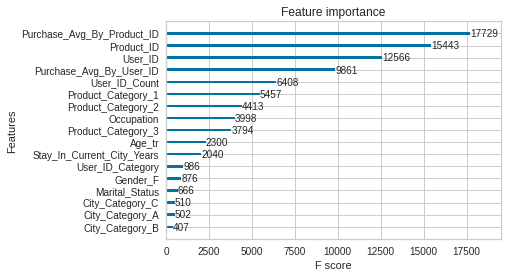

In [ ]:

xgb.plot_importance(xg_reg)
plt.show()

In [ ]:
y_test = xg_reg.predict(test_df)
submission = pd.DataFrame()
submission['Purchase'] = y_test
submission['User_ID'] = test_df_copy['User_ID']
submission['Product_ID'] = test_df_copy['Product_ID']

import datetime
FORMAT = '%Y%m%d%H%M%S'
timestamp=datetime.datetime.now().strftime(FORMAT)
filename ="Submission_xgboost_"+timestamp+"_out.csv"
out_path = '/content/drive/My Drive/datasource/blackfriday/{filename}'
out_path = out_path.format(filename= filename)
submission.to_csv(out_path,index=False)